#This notebook contains sample code that can be used to run the experiments and generate the figures that are contained within the thesis project 'Modeling Heterogeneous Seasonality with Recurrent Neural Networks Using IoT Time Series Data for Defrost Detection and Anomaly Analysis'.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/SmartSense_Project
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SmartSense_Project


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
%tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, CuDNNLSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Import all functions that are needed to create the simulated refrigeration 
# temperature dataset and the toy datasets.
from Refrigeration_Unit_Simulation import *
from Generate_Binary_Datasets import *

#Phase 1: Defrost Detection

We start by building a dataset of simulated refrigeration temperature data.

In [ ]:
# X is the temperature data, Y is the defrost label data.
X,Y,_ = simulate_refrigerator_data(num_simulations=22000, time_series_len=500, \
                                   x0y0_ratio=0.50, x1y1_ratio=0.50, \
                                   x1y0_ratio=0)

Let us plot the first example in the dataset to see how the temperature data and defrost labels are <br>related.  This is the code for Figure 3.

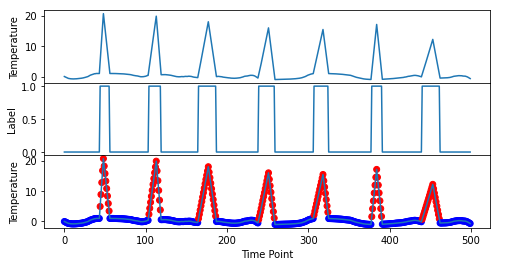

In [ ]:
fig, axs = plt.subplots(3, sharex=True, sharey=False, \
                        gridspec_kw={'hspace': 0}, figsize=(8,4))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, \
                right=False)
plt.xlabel('Time Point', fontsize=10)
axs[0].plot(X[0])
axs[0].set(ylabel='Temperature')
axs[1].plot(Y[0])
axs[1].set(ylabel='Label')
colormap = np.array(['b','r'])
axs[2].scatter(np.arange(len(X[0])), X[0], c=colormap[Y[0].astype(int)])
axs[2].plot(X[0])
axs[2].set(ylabel='Temperature')
for ax in axs:
    ax.label_outer()
plt.show()

Next we preprocess the data, which included splitting the dataset into training, validation, and test <br>sets.  Then we build the recurrent neural network and train it with the training data.  Finally, we print <br>out the confusion matrix and the performance metrics.  Note that the results shown here do not <br>match any of the results described in the thesis document, since this is not one of the training <br>attempts that made it into the selection.

In [ ]:
# Reduce Y to its last time points, since these are what the network will be 
# trained to predict.
Y = Y[:,-1]

# Create training, validation, and test sets
N = 20000 # Size of training set
x_train, x_val, x_test = X[0:N,:], X[N:(N+1000),:], X[(N+1000):,:]
y_train, y_val, y_test = Y[0:N], Y[N:(N+1000)], Y[(N+1000):]

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

# Build Recurrent Neural Network
model = Sequential()
model.add(CuDNNLSTM(10, return_sequences=True))
model.add(CuDNNLSTM(10))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', \
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, batch_size=8, epochs=30, verbose=0, \
                    validation_data=(x_val, y_val), shuffle=True)

model = load_model('Models/model_RNN_CuDNN_2Layer_10Neuron_SimData_50_50_\
NoNoise_15epoch_20K_TrainData.h5')

# Print the Performance Metrics
from sklearn.metrics import confusion_matrix
predictions = model.predict_classes(x_test)
cf = confusion_matrix(y_test, np.reshape(predictions, (len(predictions),)))
print(cf)
print('sensitivity: ', cf[1][1]/(cf[1][1]+cf[1][0]))
print('specificity: ', cf[0][0]/(cf[0][0]+cf[0][1]))
print('precision:   ', cf[1][1]/(cf[1][1]+cf[0][1]))

[[386 177]
 [ 29 408]]
sensitivity:  0.9336384439359268
specificity:  0.6856127886323268
precision:    0.6974358974358974


Let us examine the performance of the trained model using classification plots.  We will use <br>real refrigeration temperature data.  This is code for Figures 9 and 10.

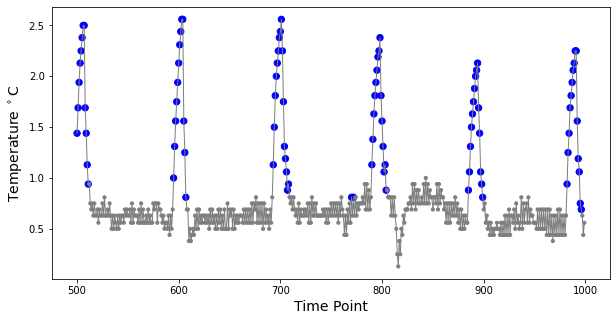

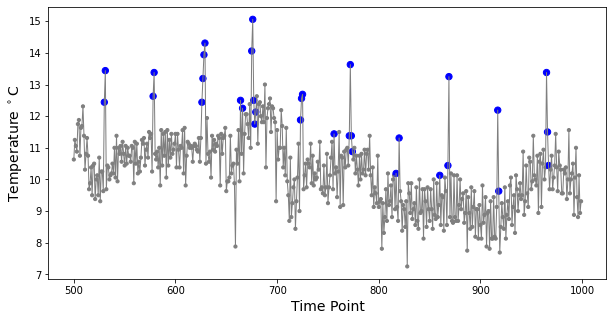

In [ ]:
file = open('train_data.pickle', 'rb')
data = pickle.load(file)
file.close()

model = load_model('Models/model_RNN_CuDNN_2Layer_10Neuron_SimData_50_50_\
NoNoise_15epoch_20K_TrainData.h5')

t = data[52][3000:4000]
test_predictions = predict_consecutive_readings(readings=t, look_back=500, \
                                                model=model)
test_predictions = np.reshape(test_predictions, (500))
plt.figure(figsize = (10,5))
plt.plot(np.arange(500,1000), t[499:999], c='tab:gray', linewidth=1)
colormap = np.array(['tab:gray','b'])
sizemap = np.array([10,40])
plt.scatter(np.arange(500,1000), t[499:999], \
            c=colormap[test_predictions.astype(int)], \
            s=sizemap[test_predictions.astype(int)])
plt.xlabel('Time Point', fontsize=14)
plt.ylabel('Temperature $^\circ$C', fontsize=14)
plt.show()

t = data[63][3000:4000]
test_predictions = predict_consecutive_readings(readings=t, look_back=500, \
                                                model=model)
test_predictions = np.reshape(test_predictions, (500))
plt.figure(figsize = (10,5))
plt.plot(np.arange(500,1000), t[499:999], c='tab:gray', linewidth=1)
colormap = np.array(['tab:gray','b'])
sizemap = np.array([10,40])
plt.scatter(np.arange(500,1000), t[499:999], \
            c=colormap[test_predictions.astype(int)], \
            s=sizemap[test_predictions.astype(int)])
plt.xlabel('Time Point', fontsize=14)
plt.ylabel('Temperature $^\circ$C', fontsize=14)
plt.show()

## Attempt to Remediate Poor Modeling of Seasonality.

So far, all trained models have failed to demonstrate that they are effectively using seasonality in <br>their classification decisions.
Therefore, we now build two additional datasets, each of which <br>feature "counterfeit defrosts".  The presence of these confounding features will hopefully force the <br>RNN to learn to leverage seasonality in its classification decisions.

In [ ]:
X2,Y2,_ = simulate_refrigerator_data(num_simulations=22000, \
            time_series_len=500, x0y0_ratio=0.50, x1y1_ratio=0.50, x1y0_ratio=0)
X3,Y3,_ = simulate_refrigerator_data(num_simulations=22000, \
            time_series_len=500, x0y0_ratio=0.50, x1y1_ratio=0.50, x1y0_ratio=0)

We now use the previous code to train two additional models.  After the two models are <br>trained, we load all three models and compare their classification performances on a <br>simulated time series.  This is code for Figure 12.

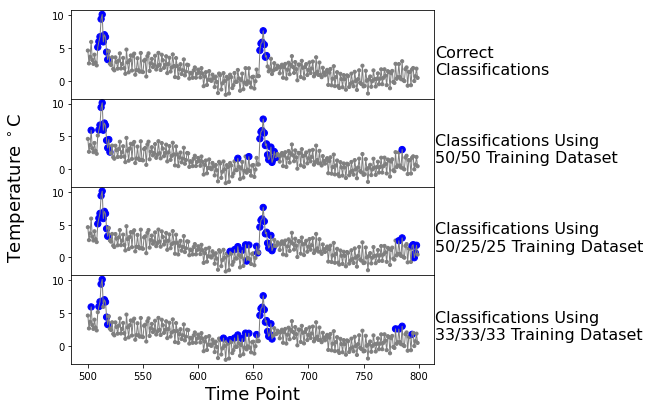

In [ ]:
model1 = load_model('Models/model_RNN_CuDNN_2Layer_10Neuron_SimData_50_50_\
NoNoise_15epoch_20K_TrainData.h5')
model2 = load_model('Models/model_RNN_CuDNN_2Layer_10Neuron_SimData_50_25_25_\
NoNoise_15epoch_20K_TrainData.h5')
model3 = load_model('Models/model_RNN_CuDNN_2Layer_10Neuron_SimData_33_33_33_\
NoNoise_15epoch_20K_TrainData.h5')

np.random.seed(886); random.seed(886)
n=1000
t, y, i = generate_simulation(n=n, end_in_defrost=False, \
                              end_in_fake_defrost=False)
plot_len = 300
look_back = 500
plot_start = look_back-1
plot_end = plot_start + plot_len
test_predictions1 = np.reshape(predict_consecutive_readings(readings=t, \
                  look_back=look_back, model=model1), (n-look_back))[:plot_len]
test_predictions2 = np.reshape(predict_consecutive_readings(readings=t, \
                  look_back=look_back, model=model2), (n-look_back))[:plot_len]
test_predictions3 = np.reshape(predict_consecutive_readings(readings=t, \
                  look_back=look_back, model=model3), (n-look_back))[:plot_len]
colormap = np.array(['tab:gray','b'])
sizemap = np.array([10,40])

fig, axs = plt.subplots(4, sharex=True, sharey=False, \
                        gridspec_kw={'hspace': 0}, figsize=(6.5,6.5))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, \
                left=False, right=False)
plt.xlabel('Time Point', fontsize=18)
plt.ylabel('Temperature $^\circ$C', labelpad=20, fontsize=18)
axs[0].plot(np.arange(look_back,look_back+plot_len), t[plot_start:plot_end], \
            c='tab:gray', linewidth=1)
axs[0].scatter(np.arange(look_back,look_back+plot_len), t[plot_start:plot_end], \
               c=colormap[y[plot_start:plot_end].astype(int)], \
               s=sizemap[y[plot_start:plot_end].astype(int)])
axs[0].text(x=815, y=1, s='Correct\nClassifications', fontsize=16)
axs[1].plot(np.arange(look_back,look_back+plot_len), t[plot_start:plot_end], \
            c='tab:gray', linewidth=1)
axs[1].scatter(np.arange(look_back,look_back+plot_len), t[plot_start:plot_end], \
               c=colormap[test_predictions1.astype(int)], \
               s=sizemap[test_predictions1.astype(int)])
axs[1].text(x=815, y=1, s='Classifications Using\n50/50 Training Dataset', \
            fontsize=16)
axs[2].plot(np.arange(look_back,look_back+plot_len), t[plot_start:plot_end], \
            c='tab:gray', linewidth=1)
axs[2].scatter(np.arange(look_back,look_back+plot_len), t[plot_start:plot_end], \
               c=colormap[test_predictions2.astype(int)], \
               s=sizemap[test_predictions2.astype(int)])
axs[2].text(x=815, y=1, s='Classifications Using\n50/25/25 Training Dataset', \
            fontsize=16)
axs[3].plot(np.arange(look_back,look_back+plot_len), t[plot_start:plot_end], \
            c='tab:gray', linewidth=1)
axs[3].scatter(np.arange(look_back,look_back+plot_len), t[plot_start:plot_end], \
               c=colormap[test_predictions3.astype(int)], \
               s=sizemap[test_predictions3.astype(int)])
axs[3].text(x=815, y=1, s='Classifications Using\n33/33/33 Training Dataset', \
            fontsize=16)
for ax in axs:
    ax.label_outer()
plt.show()

# Phase 2: Toy Dataset Experiments
## Toy Dataset 1

We start by creating Toy Dataset 1, whose seasonal components have homogenous periods <br>and heterogeneous temporal positions.

In [ ]:
num_runs = 16000
N = 15000 # Size of training set
len_run=501

num_x0y0 = int(num_runs/2)
num_x1y1 = int(num_runs/2)
num_x1y0 = int(num_runs*0)

X,Y,P = generate_binary_training_data(len_run=len_run, noise=False, period=100, \
                              period_range=None, start=None, num_x0y0=num_x0y0, \
                                      num_x1y1=num_x1y1, num_x1y0=num_x1y0)

In order to better understand the dataset, we plot a few examples from the dataset and their <br>seasonal components.  This is code for Figure 5.

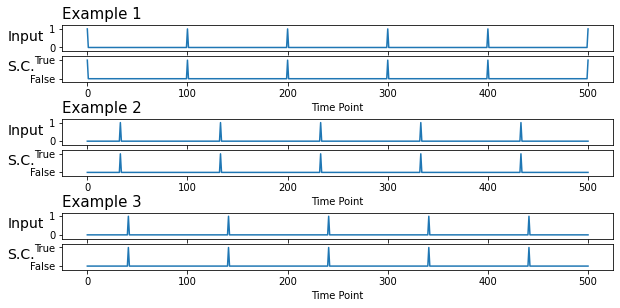

In [ ]:
fig = plt.figure(figsize = (4.5,4.5), frameon=False, linewidth=10, edgecolor='b')
for i in range(3):
  #X,Y,p = generate_binary_run(len_run=500, noise=True, period=100, start=None)
  subplot_loc = 3*i+1
  axs = fig.add_subplot(8, 1, subplot_loc) 
  axs.plot(X[i])
  axs.set_yticks(ticks=np.array([0,1]))
  axs.set_ylim([-.2,1.2])
  axs.text(x=-80, y=0.35, s='Input', fontsize=14)
  axs.set_title('Example {i}'.format(i=(i+1)), loc='left', fontsize=15)
  axs = fig.add_subplot(8, 1, subplot_loc+1) 
  axs.plot(Y[i])
  axs.set_yticks(ticks=np.array([0,1]))
  axs.set_ylim([-.2,1.2])
  axs.set_yticklabels(np.array(['False', 'True']))
  axs.text(x=-80, y=0.4, s='S.C.', fontsize=14)
  axs.set_xlabel('Time Point')
fig.subplots_adjust(left=0.3, right=2)
plt.show()

We split Toy Dataset 1 into training and test sets.  We use the training set to train an RNN, and <br>then use the test set to generate performance metrics.  Note that these metrics are slightly <br>different from the results shown in the body of the Thesis, since those results were acheived <br>after many attempts at training.

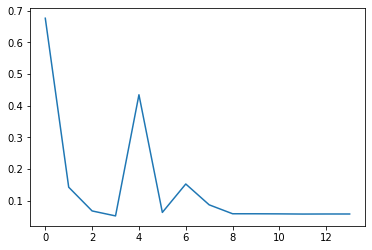

[[493  12]
 [  0 495]]
sensitivity:  1.0
specificity:  0.9762376237623762
precision:    0.9763313609467456


In [ ]:
X = np.reshape(X, (X.shape[0],X.shape[1],1))
x_train, x_test = X[:N,:-1], X[N:,:-1]
y_train, y_test = X[:N,-1,0], X[N:,-1,0]

model_RNN = Sequential()
model_RNN.add(CuDNNLSTM(10))
model_RNN.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.01)
model_RNN.compile(loss='binary_crossentropy', optimizer=optimizer, \
                  metrics=['accuracy'])
callback = EarlyStopping(monitor='val_acc', restore_best_weights=True, \
                         patience=10)
history = model_RNN.fit(x_train, y_train, batch_size=64, epochs=30, verbose=0, \
                        validation_data=(x_test, y_test), shuffle=True,\
                        callbacks = [callback])

plt.plot(history.history["val_loss"]); plt.show()

from sklearn.metrics import confusion_matrix
tt = model_RNN.predict_classes(x_test)
cf = confusion_matrix(y_test, np.reshape(tt, (len(tt),)))
print(cf)
print('sensitivity: ', cf[1][1]/(cf[1][1]+cf[1][0]))
print('specificity: ', cf[0][0]/(cf[0][0]+cf[0][1]))
print('precision:   ', cf[1][1]/(cf[1][1]+cf[0][1]))

We visualize the RNN's forecasting performance by generating three new time series and <br>creating forecasting plots.  The plots demonstrate that the forecasts are accurate.  This is code <br>for Figure 13.

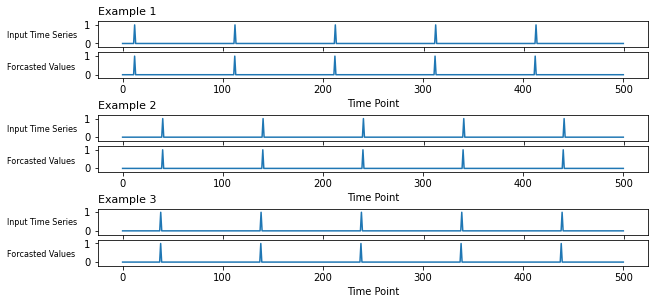

In [ ]:
fig = plt.figure(figsize = (4.5,4.5), frameon=False, linewidth=10, \
                 edgecolor='b')
for i in range(3):
  x, y, p = generate_binary_training_data(len_run=(1000), period=100, \
                                          start=None, num_x0y0=1, noise=False)
  x = np.ravel(x)
  y_hat = predict_consecutive_binary_readings(readings=x, look_back=499, \
                                              model=model)
  subplot_loc = 3*i+1
  axs = fig.add_subplot(8, 1, subplot_loc) 
  axs.plot(x[499:999])
  axs.set_yticks(ticks=np.array([0,1]))
  axs.set_ylim([-.2,1.2])
  axs.text(x=-115, y=0.3, s='Input Time Series', fontsize=8)
  axs.set_title('Example {i}'.format(i=(i+1)), loc='left', fontsize=11)
  axs = fig.add_subplot(8, 1, subplot_loc+1) 
  axs.plot(np.arange(0,len(y_hat)),y_hat)
  axs.set_yticks(ticks=np.array([0,1]))
  axs.set_ylim([-.2,1.2])
  axs.text(x=-115, y=0.25, s='Forcasted Values', fontsize=8)
  axs.set_xlabel('Time Point', fontsize=10)
fig.subplots_adjust(left=0.3, right=2)
plt.show()

We can now tweek the above cells to create, train with, and test Toy Datasets 2, 3, and 4.  <br>When building Toy Datasets 2 and 4, we set 'noise' to True.  When building Toy Datasets 3 <br>and 4, we set 'period' to None and we set 'period_range' to (2,100).